# <a id='toc1_'></a>[sport-adverse-events](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [sport-adverse-events](#toc1_)    
  - [init code](#toc1_1_)    
  - [(optional) decrypt data](#toc1_2_)    
  - [load data](#toc1_3_)    
  - [arrange data](#toc1_4_)    
    - [set columns](#toc1_4_1_)    
    - [parse dates to datetime 🕥](#toc1_4_2_)    
  - [reduce data](#toc1_5_)    
    - [(optional) remove columns w/ no or few values](#toc1_5_1_)    
    - [(optional) merge excel columns with csv columns](#toc1_5_2_)    
  - [show data](#toc1_6_)    
  - [💾 data for pivot use](#toc1_7_)    
  - [analysis showcase 📈](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[init code](#toc0_)

In [41]:
import io
import os
from glob import glob
import pandas as pd
from pathlib import Path
from pandas_plots import tbl, pls
from connection_helper import pgp
from dotenv import load_dotenv, find_dotenv
import missingno as mi
import re

os.environ["THEME"]="light"

dir_data_in=Path("../data/in")
dir_data_out=Path("../data/out")

# ! only 1 csv file in in/ is allowed
file_csv_list=glob(f"{dir_data_in}/*.csv")
assert len(file_csv_list) == 1, f"❌ Expected 1 csv file, found {len(file_csv_list)}"

file_csv = file_csv_list[0]
file_xls=Path(dir_data_in/"Register_fertig.xlsx")

## <a id='toc1_2_'></a>[(optional) decrypt data](#toc0_)

In [42]:
# # * get .env file and expect KEY_PIN
# _path_env = find_dotenv()
# if _path_env:
#     load_dotenv(_path_env)
# _key_pin = os.getenv("KEY_PIN")

# encr_file_path=".local/RegisterZurErfassung_DATA_LABELS_2024-01-11_1301.csv.gpg"
# result=pgp.pgp_decrypt(message_file_path=encr_file_path,passphrase=_key_pin)

## <a id='toc1_3_'></a>[load data](#toc0_)
- ⚠️ strategy to import the csv raw data:
  - ❌ do not use default `pd.read_csv()`, its not as error tolerant as excel
  - ✅ read csv as `windows-1252` string and cleanse it
    - most (not all) lines have heading + trailing quotes, remove
    - data have a mixture of "" and ", downgrade by 1
    - delimiter "," also occurs in quotes, change to ";" only outside of quotes
    - now byte stream can be imported

### excel import to get columns

In [43]:
#
# * read excel
df_xls=pd.read_excel(file_xls, sheet_name="Tabelle fertig")

### option clean csv

In [44]:
df_csv = pd.read_csv(file_csv, sep=",", encoding="utf-8-sig")

### option dirty csv

In [45]:
#
# * replace delimiter *only* outside of quotes
def replace_delimiter_outside_quotes(
    input: str, delimiter_old: str = ",", delimiter_new: str = ";", quotechar: str = '"'
):
    outside_quotes = True
    output = ""
    # * loop through input and toggle inside/outside status
    for char in input:
        if char == quotechar:
            outside_quotes = not outside_quotes
        elif outside_quotes and char == delimiter_old:
            char = delimiter_new
        output += char
    return output

In [46]:
#
# * downgrades quotes in string to normalize quots: " -> NA, "" -> "
def reduce_quotes_in_string(input: str):
    output = ""
    len_=len(input)
    i = 0
    while i < len_:
        # * check current + next char if within range
        if input[i] == '"' and i+1 < len_ and input[i+1] != '"':
            output += ''
            i = i+1
        elif input[i] == '"'and i+1 < len_ and input[i+1] == '"':
            output+= '"'
            i = i+2
        else:
            output += input[i]
            i=i+1
    return output

In [47]:
%%script echo skipping

# * read csv -> variable
with open(file_csv, encoding="windows-1252") as f:
    csv=f.read()

# * selectively change , into ;
csv_lines = csv.splitlines()
csv_lines_new = []
for line in csv_lines[:]:
    # * remove first and last quotes if present
    if line[:1] == '"':
        line = line[1:-1]
    # * tailor line by line
    line=reduce_quotes_in_string(line)
    line=replace_delimiter_outside_quotes(line)
    # * just now quotes can be removed, not before
    line=line.replace('"', '')
    csv_lines_new.append(line)
    # print(f'{line.count(";")} {line}')

# * list -> string fo feed into df constructor
csv_string = "\n".join(csv_lines_new).replace('\t', '')

df_csv = pd.read_csv(
    io.StringIO(csv_string),
    sep=";",
    encoding="windows-1252",
)


Couldn't find program: 'echo'


## <a id='toc1_4_'></a>[arrange data](#toc0_)

### <a id='toc1_4_1_'></a>[set columns](#toc0_)

In [48]:
# * prevent float conversion due to NA
if 'CTCAE-Bewertung' in df_csv.columns:
    df_csv['CTCAE-Bewertung'] = df_csv['CTCAE-Bewertung'].astype('Int64')
# * mix date values into on1, these are disjoint
# df_csv['Datum'].fillna(df_csv['Survey Timestamp'], inplace=True)
# * get date column
col_date = list(set(df_csv.columns) & set(["date_1", "Datum"]))[0]

### <a id='toc1_4_2_'></a>[parse dates to datetime 🕥](#toc0_)

In [49]:
%%script echo skipping

# hack
# * manual override if needed
df_csv.loc[df_csv["Datum"]=="2023_08_2028","Datum"]="2023_08_28"
# * parse date col
REG_DATE_YYYY_MM=r"\d{4}_\d{2}$"
REG_DATE_YYYY_MM_DD=r"\d{4}_\d{2}_\d{2}$"

# * get all data from YYYY_MM
_df1=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM, na=False)]["Datum"]
_df2=df_csv[df_csv["Datum"].str.contains(REG_DATE_YYYY_MM_DD, na=False)]["Datum"]

# * convert to datetime
_df1=pd.to_datetime(_df1, format="%Y_%m").astype(str)
_df2=pd.to_datetime(_df2, format="%Y_%m_%d").astype(str)

# * update in place
df_csv.update(_df1)
df_csv.update(_df2)

# * now convert the whole col
df_csv["Datum"]=pd.to_datetime(df_csv["Datum"], format='ISO8601')

Couldn't find program: 'echo'


## <a id='toc1_5_'></a>[reduce data](#toc0_)

### <a id='toc1_5_1_'></a>[(optional) remove columns w/ no or few values](#toc0_)

In [50]:
# * remove columns with no value
cols_no_value = [col for col in df_csv.columns if df_csv[col].isna().all()]
print("these columns have no values at all:")
display(df_csv[cols_no_value][:3])

# * show columns with few values
# _few_values_threshold = 3
# cols_few_values = [col for col in df_csv.columns if (df_csv[col].notna().sum() < _few_values_threshold and df_csv[col].notna().any())]
# df_csv[cols_few_values][:10]

# ! remove columns
cols_after_removal = list(set(df_csv.columns) - set(cols_no_value))
df_csv = df_csv[list(set(df_csv.columns) - set(cols_no_value))]

these columns have no values at all:


,redcap_survey_identifier,was_genau,konsequenz6,back_up_792022_timestamp,standort2022_7_9,koseq_sons2022_7_9,dauer2022_7_9,neu2022_7_9,vorher2022_7_9,anlass2022_7_9,...,online_v2,testung_2_v2,setting_v2,sett_sons_v2,verlauf_v2,grund_sonstiges_v2,phase_v2,asso_v2,zustand_sons_v2,backup_rr_1310_complete
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <a id='toc1_5_2_'></a>[(optional) merge excel columns with csv columns](#toc0_)

In [51]:
%%script echo skipping

# * dont use set operations to maintain order
_len_before=len(df_csv.columns)
cols_csv_and_excel=[col for col in df_xls.columns if col in df_csv.columns]
# * append exceptions if desired
# cols_csv_and_excel.append("Survey Timestamp")

# ! reduce columns
df_csv = df_csv[cols_csv_and_excel]

print(f"merged csv columns ({_len_before}) with excel columns ({len(df_xls.columns)}) into ({len(df_csv.columns)})")

Couldn't find program: 'echo'


## <a id='toc1_6_'></a>[show data](#toc0_)

🔵 *** df: df_csv ***
🟣 shape: (60, 146) columns: ['konsequenz3___2', 'basis9___4', 'behandlung_v2___8', 'koni_9', 'behandlung2022_7_9___2', 'basis9___2', 'was', 'konsequenzen2022_7_9___14', 'behandlung2022_7_9___9', 'basis9___1', 'konsequenzen_v2___8', 'schmerz_skala', 'ablauf3a', 'basis9___5', 'konsequenz2___3', 'behandlung2022_7_9___6', 'motorischehauptform2022_7_9___5', 'koni_7', 'konsequenzen2022_7_9___3', 'konsequenz12', 'standort2', 'konsequenz3___4', 'einfluss2', 'konsequenzen_v2___10', 'konsequenzen2022_7_9___1', 'konsequenzen_v2___3', 'konsequenzen2022_7_9___8', 'behandlung_v2___6', 'koni_5', 'basis2', 'behandlung2022_7_9___7', 'handlung1bc', 'motorischehauptform2022_7_9___2', 'koni_12', 'konsequenzen_v2___11', 'koni_13', 'participant_id', 'konsequenz8', 'konsequenz2___4', 'pause_dauer', 'konsequenz9', 'konsequenzen4', 'konsequenzen_v2___5', 'trost', 'trainingszustand_v2___3', 'koni_3', 'risikoregister_2022_13_10_timestamp', 'koni_8', 'ausloeser_ae', 'behandlung2022_7_9___5', 

,konsequenz3___2,basis9___4,behandlung_v2___8,koni_9,behandlung2022_7_9___2,basis9___2,was,konsequenzen2022_7_9___14,behandlung2022_7_9___9,basis9___1,...,konsequenzen_v2___6,konsequenzen2022_7_9___5,motorischehauptform_v2___5,konsequenzen2022_7_9___15,behandlung2022_7_9___8,konsequenzen_v2___9,welche_koni,konsequenzen_2_v2___4,basis1,konsequenzen_v2___4
0,0,0,0,NaN,0,0,NaN,0,0,0,...,0,0,0,0,0,0,nan,0,NaN,0
1,0,0,0,2.0,0,1,3.0,0,0,0,...,0,0,0,0,0,0,nan,0,3.0,0
2,0,0,0,2.0,0,1,2.0,0,0,0,...,0,0,0,0,0,0,nan,0,1.0,0


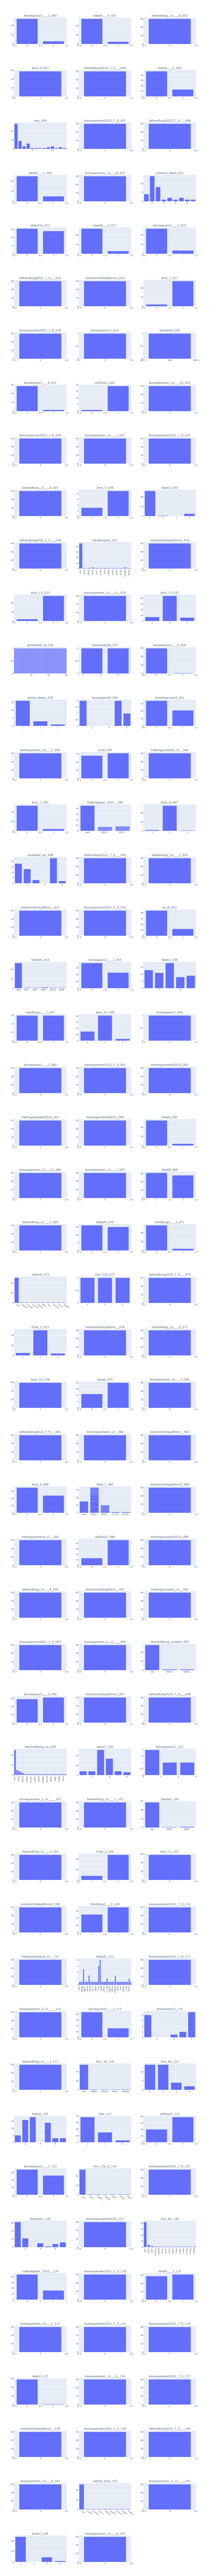

In [52]:
tbl.describe_df(df_csv.iloc[:,:], "df_csv", top_n_uniques=5, top_n_chars_in_index=5, use_plot=True, top_n_chars_in_columns=20)

## <a id='toc1_7_'></a>[💾 data for pivot use](#toc0_)

In [58]:
df_csv.reset_index().to_csv(Path(dir_data_out/"df_csv.csv"),sep=";", index=False, encoding="utf-8-sig")
df_csv.reset_index().to_excel(Path(dir_data_out/"df_csv.xlsx"), index=False)

## <a id='toc1_8_'></a>[analysis showcase 📈](#toc0_)

<Axes: >

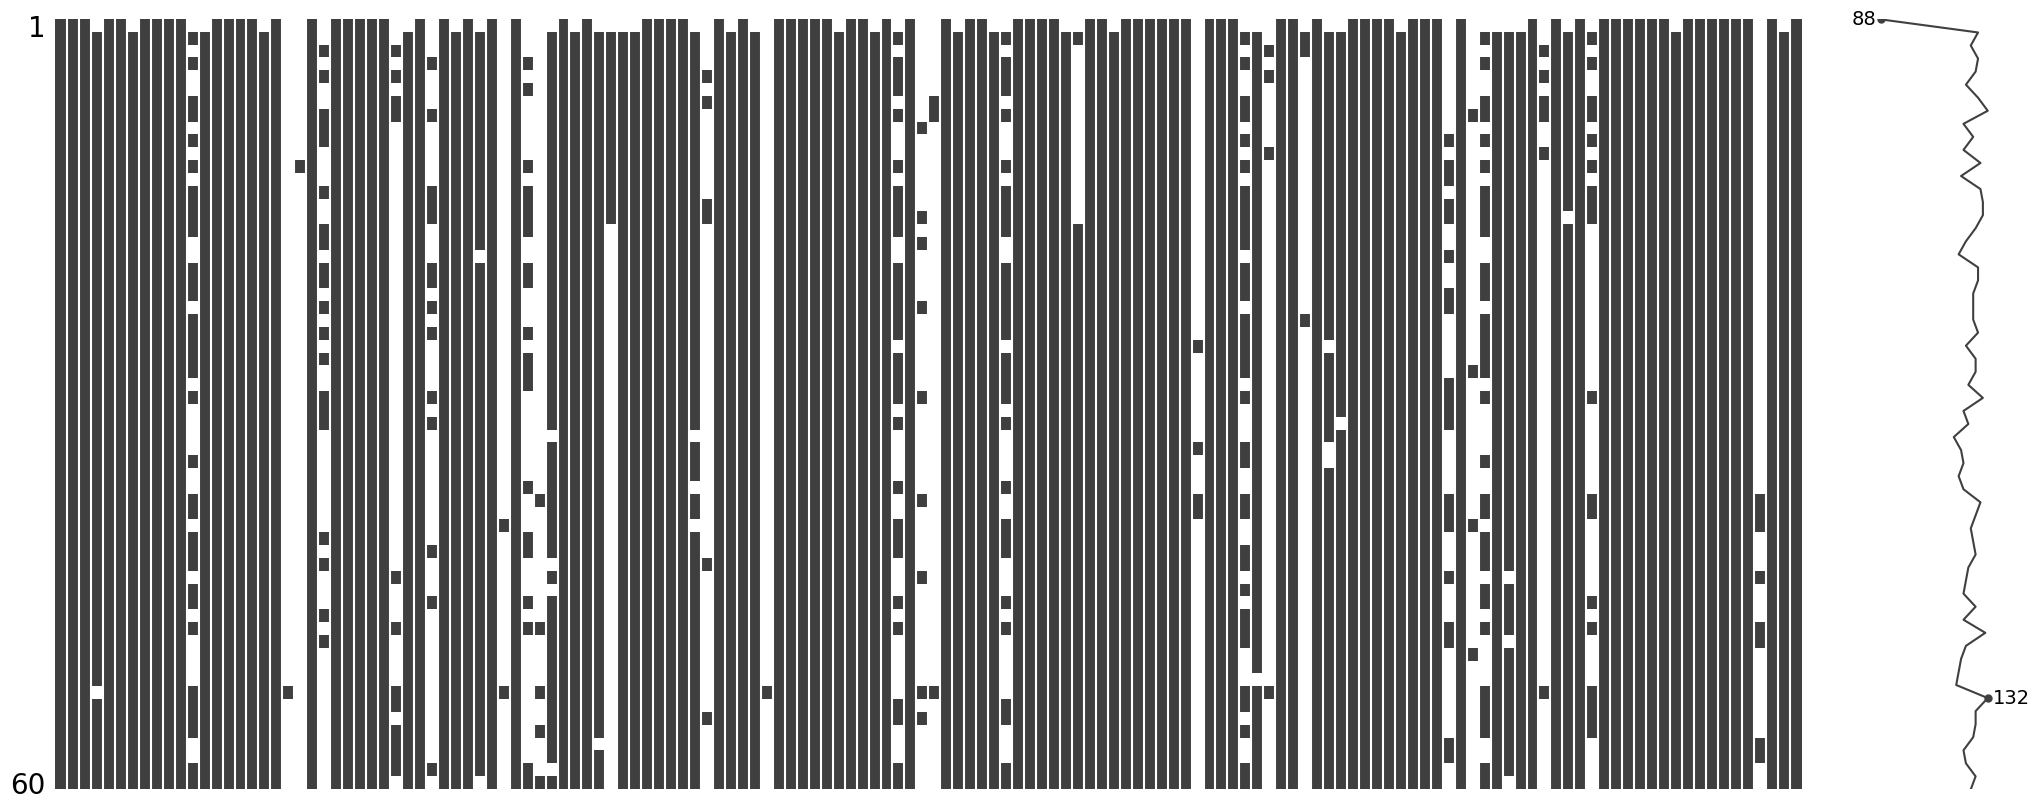

In [54]:
mi.matrix(df_csv)
# mi.bar(df_csv)

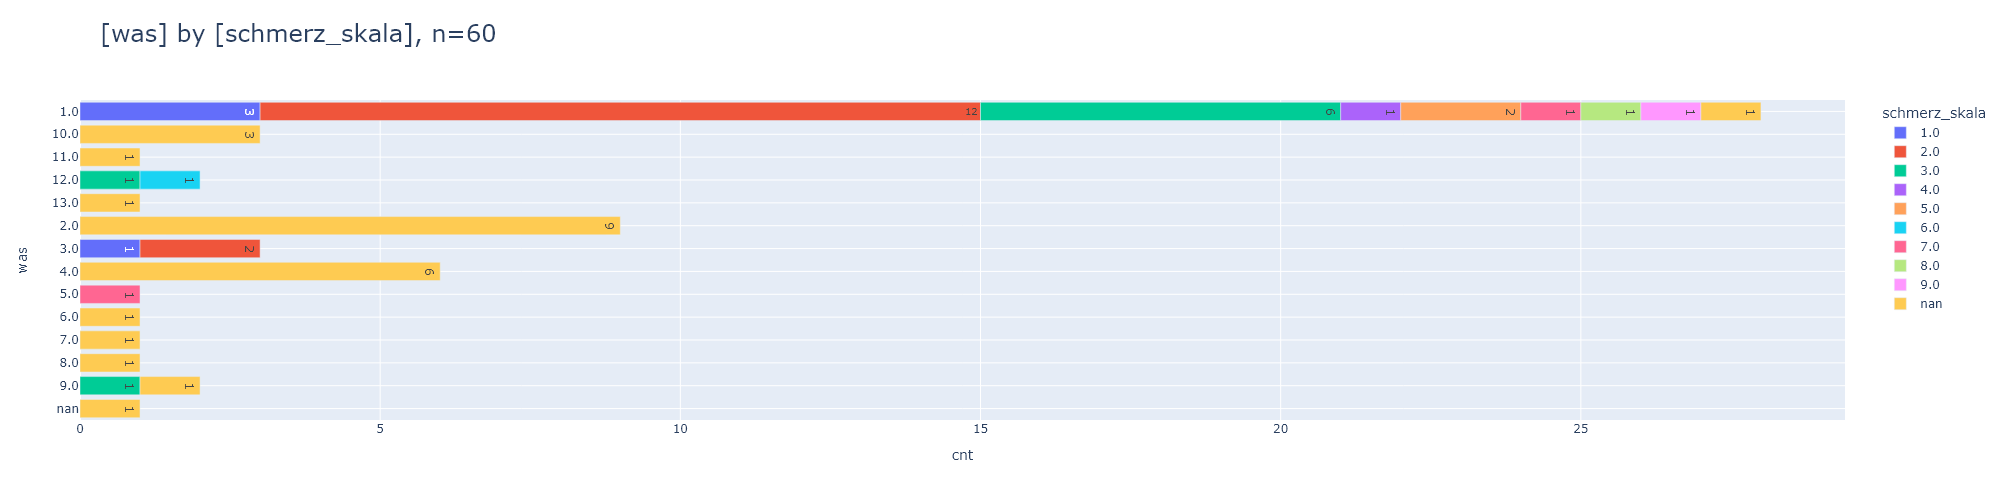

In [63]:
_df=df_csv[['schmerz_skala', 'was']].astype(str)
pls.plot_stacked_bars(_df, orientation="h", swap=True)